# Modular meta-learning

The modular meta-learning method introduced in [1] enables combinatorial generalisation and generalises to new tasks by optimizing a set of neural network modules that can be composed in different ways to solve a new task, without changing their internal parameters. 

Accordingly, the method constructs a repository of fixed graph filters that can be combined to define a (power control) policy, parametrized by a graph neural network (GNN). In contrast to existing modular meta-learning schemes that rely on variants of simulated annealing, the proposed method adopts a stochastic module assignment based on the Gumbel-softmax reparametrization trick [2],[3], which enables optimization via standard SGD.

In this notebook, we describe the different parts of the proposed modular meta-learning method, in the context of power control.

Any thoughts or questions? We would love to hear any feedback on this notebook, or the method in general. Please contact us on ivana.nikoloska@kcl.ac.uk.

# Implementing modular meta-learning

We start by importing the necessary dependencies. We will make use of numpy, pickle, and tensorflow.

In [23]:
import tensorflow.compat.v1 as tf
import numpy as np
import pickle
import os
import pdb
from random import seed
from random import randint
import tensorflow_probability as tfp
tfd = tfp.distributions

We now define some useful hyper-parameters.

In [24]:
# Eperiment ID
dataID = 1

# Default shape for tf.variables used for initialization
dif_shape = 10

# Path gain exponent
pl = 2.2

# Rayleigh distribution scale
alpha = 1 

# Batch size
batch_size = 64

# Number of training samples for meta-training in each task
tr_iter = 50

# Number of testing samples for meta-training in each task
te_iter = 50

# Number of training samples for meta-testing 
meta_tr_iter = 10 

# Number of testing samples for meta-testing 
meta_te_iter = 1000 

# Max power
Pmax = 1

# Noise power
var=7e-10

# Hidden features
#num_hidden = 5

# Output shape
num_classes = 1

# Input shape
feature_dim = 1

# Number of filters
no_filters = 4

# Number of modules
no_modules = 2

# Number of epochs - training iterations in the outer loop
num_epochs = 100 #set to 100 for MAML and REPTILE

#number of samples i.e number of shots
#num_samples = 100  

#number of tasks
num_tasks = 5 #set to 10 for MAML and REPTILE

#number of times we want to perform optimization
num_iterations = 5 # for REPTILE = 5, for MAML = 2

#mini btach size
mini_batch = 64

# Learning rate
learning_rate = 1e-3

# Max gradient norm
max_gradient_norm = 5.0

# Number of samples to evaluate expectations
#num_samples_exp = 5

# Meta-training data

A crutial property of meta-learning is that it can extract shared knowledge, in the form of an inductive bias, from data sets corresponding to distinct learning tasks in order to solve held-out tasks and adapt to new tasks (in this case, network topologies) more efficiently. 

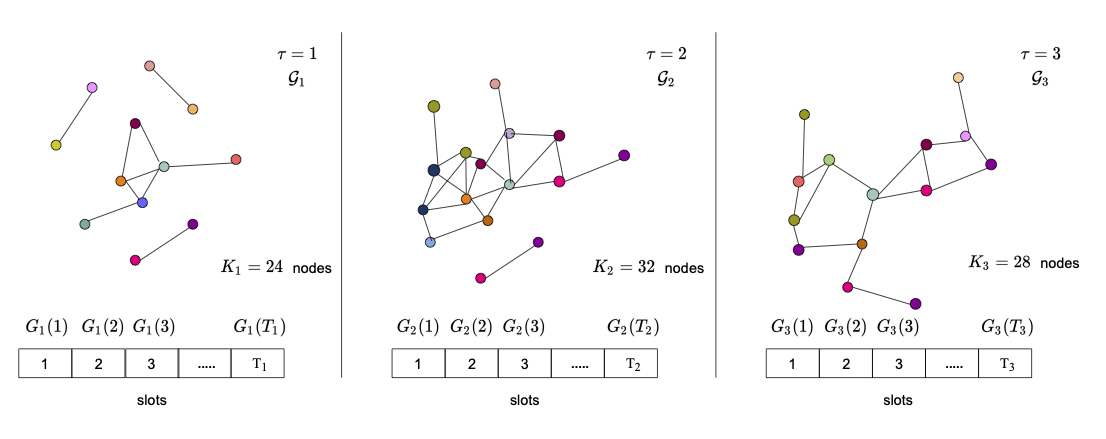

Rather than training using observations from a single network topology as it is often the case in power control via machine learning, we will use a dataset that consists of many different network topologies that share some underlying characteristics. This is visualized in the figure above. 

# Data generator

In the following section we provide the code for generating our training and testing sets. As we will explain later, we use two subset of samples at every iteration: one to serve for meta-training, and the other for meta-testing. Our data generator can be used to generate data for both subsets, providing it in the correct format.

In [25]:
# Build a random geometric graph
def build_adhoc_network( nNodes, tr, te, r=1, pl=2.2):
    transmitters = np.random.uniform(low=-nNodes/r, high=nNodes/r, size=(nNodes,2)) #locations of transmitters
    receivers = transmitters + np.random.uniform(low=-nNodes/4,high=nNodes/4, size=(nNodes,2)) #locations of receivers

    L = np.zeros((nNodes,nNodes))

    d_cutoff = 2*nNodes/3 #cutoff distance beyond which the interference can be considered equal to zero 

    for i in np.arange(nNodes):
        for j in np.arange(nNodes):
            d = np.linalg.norm(transmitters[i,:]-receivers[j,:])
            if d > d_cutoff:
                L[i,j] = 0
            else:
                L[i,j] = np.power(d,-pl)

    return( dict(zip(['tx', 'rx'],[transmitters, receivers] )), L )

# Simuate fading effects
def sample_graph(batch_size, A, nNodes, alpha=1.):
    samples = np.random.rayleigh(alpha, (batch_size, nNodes, nNodes))
    PP = samples[None,:,:] * A
    return PP[0]

# Data
def generate_data(batch_size, alpha, A, nNodes, tr, te):
    tr_H = []
    te_H = []
    
    for indx in range(tr):
        # sample training data 
        H = sample_graph(batch_size, A, nNodes, alpha )
        tr_H.append( H )

    for indx in range(te):
        # sample test data 
        H = sample_graph(batch_size, A, nNodes, alpha )
        te_H.append( H )

    return( dict(zip(['train_H', 'test_H'],[tr_H, te_H] ) ) )

# Main        
def get_data(nNodes, tr, te):
    coord, A = build_adhoc_network(nNodes, tr, te)
    
    # Create data path
    if not os.path.exists('data/'):
        os.makedirs('data/')

    # Coordinates of nodes
    f = open('data/coordinates.pkl', 'wb')  
    pickle.dump(coord, f)         
    f.close()

    # Geometric graph
    f = open('data/A.pkl', 'wb')  
    pickle.dump(A, f)          
    f.close()
    
    # Data
    data = generate_data(batch_size, alpha, A, nNodes, tr, te)
    f = open('data/H.pkl', 'wb')  
    pickle.dump(data, f)         
    f.close()

In [26]:
tf.reset_default_graph()
tf.disable_eager_execution()

In [27]:
#def sample_gumbel(shape, eps=1e-20): 
#    """Sample from Gumbel(0, 1)"""
#    U = tf.random_uniform(shape,minval=0,maxval=1)
#    return -tf.log(-tf.log(U + eps) + eps)

#def gumbel_softmax_sample(logits, temperature): 
#    """ Draw a sample from the Gumbel-Softmax distribution"""
#    y = logits + sample_gumbel(tf.shape(logits))
#    return tf.nn.softmax( y / temperature)

#def euclideanDistance(x):
#    dist = (tf.sqrt(tf.reduce_sum(tf.square(x))))**2
#    return dist

#def CKA(x, y):
#    div = euclideanDistance(tf.transpose(y)*x)/tf.cast(euclideanDistance(tf.transpose(x)*x)*euclideanDistance(tf.transpose(y)*y), tf.float32 )
#    return div

# Modular meta-learning with Gumbel-softmax

We denote by $S_\tau \in \{1,...,M\}^L$ the module assignment - a mapping between the layers $l = 1,...,L$ of the GNN and the modules from the module set $\mathcal{M} = \{\Phi^{(1)},...,\Phi^{(M)}\}$, representing a repository of filter taps. Let us represent the categorical variable $S_{\tau, l}$ using a one-hot representation $S_{\tau, l} = [S^{(1)}_{\tau, l},...,S^{(M)}_{\tau, l}]^T$, in which $S^{(i)}_{\tau, l}=1$ if $S_{\tau, l} = i$, and $S^{(i)}_{\tau, l}=0$ otherwise. With this definition, we can write the output of layer $l$ of the modular GNN as
\begin{align}
    z_{l+1} = \sum_{i = 1}^{M} S_{\tau, l}^{(i)} \left[ \sigma \left[ \sum_{n=1}^N \Phi^{(i)}_{n} (G_\tau (t))^n z_l \right]\right].
\end{align}
Using a recursive application of the previous expression, for a given module set $\mathcal{M}$ and module assignment vector $S_{\tau}$, the transmit power can be found as the output of the modular GNN as
\begin{align}
    &\textrm{f} \left(G_\tau(t) \, | \, \left[\Phi^{(S_{\tau, 1})},...,\Phi^{(S_{\tau, L})}\right]\right) = P_\text{max} \nonumber\\&
    \times \sum_{i = 1}^{M} S_{\tau, L}^{(i)} \left[ \sigma \left[ \sum_{n=1}^N \Phi^{(i)}_{n} (G_\tau (t))^n \left( ... \left(\sum_{i = 1}^{M} S_{\tau, 1}^{(i)} \left[ \sigma \left[ \sum_{n=1}^N \Phi^{(i)}_{n} (G_\tau (t))^n x \right]\right) ...\right) \right] \right] \right].
\end{align}

We now define a stochastic module assignment function given by the conditional distribution $\mathcal{P}_\tau (S_\tau |  \mathcal{M}, \mathcal{D}^{\text{tr}}_\tau)$. This distribution assigns probabilities to each one of the $M^L$ possible assignment vectors $S_\tau$, given the module set $\mathcal{M}$ and training data $\mathcal{D}^{\text{tr}}_\tau$ for the current period $\tau$.
We model the module assignment distribution $\mathcal{P}_\tau(S_\tau |  \mathcal{M}, \mathcal{D}^{\text{tr}}_\tau)$ by using a mean-field factorization across the layers of the GNN, i.e., 
\begin{align}
    \mathcal{P}_\tau(S_\tau \, | \, \mathcal{M}, \mathcal{D}^{\text{tr}}_\tau) = \prod_{l=1}^L \mathcal{P}_\tau(S_{\tau, l} \, | \, \mathcal{M}, \mathcal{D}^{\text{tr}}_\tau),
\end{align}
where $S_{\tau, l} \in \{1,...,M\}$ is the $l$-th entry of the vector $S_{\tau}$. 
Then, we let $\eta_{\tau, l} = [\eta^{(1)}_{\tau, l}, ..., \eta^{(M)}_{\tau, l}]^T$, be the vector of logits that parametrize the assignment probabilities through the softmax function as
\begin{align}
    \mathcal{P}_\tau(S_{\tau, l} = i \, | \, \mathcal{M}, \mathcal{D}^{\text{tr}}_\tau) = \frac{\exp(\eta_{\tau, l}^{(i)})}{\sum_{i'=1}^{M} \exp(\eta_{\tau, l}^{(i')})}.
\end{align}


The Gumbel-Max trick [2],[3] provides a simple and efficient way to draw a sample $S_{\tau,l}$ from a categorical distribution with logits $\eta_{\tau, l}$ as
\begin{align}
    {S}_{\tau, l}^{(i)} = {1} \,\,\, \left( \underset{i' \in \{1,...,M\}}{\text{argmax}} \,\,\, (\eta_{\tau, l}^{(i')} + \epsilon_l^{(i')}) = i \right), \,\,\,\, \text{for} \,\,\,\, i = 1,...,M,
\end{align}
where ${1} (x)$ denotes the indicator function which equals one if the assignment is true, and zero otherwise; and  $\epsilon_l^{(i)}$ represent independent Gumbel variables obtained as
\begin{align}
    \epsilon_l^{(i)} = -\log (-\log (n^{(i)}_l)), \,\,\,\, \text{for} \,\,\,\, i = 1,...,M,
\end{align}
with $n^{(i)}_l$ being independent uniform random variables, i.e., $n^{(i)}_l \sim \text{Uniform} (0,1)$.
Thereby, by using the Gumbel-Max trick, the sampling of a discrete random variable is reduced to applying a deterministic function of the parameters $\eta_{\tau, l}^{(i)}$ to noise variables drawn from a fixed distribution. 

The argmax operation however, is not differentiable, making the optimization of the parameter vectors $\{\eta_{\tau, l}\}_{l=1}^L$ via SGD infeasible. To address this issue, as in [2],[3], we adopt the softmax function as a continuous, differentiable approximation. Samples from the resulting concrete distribution can be drawn according to
\begin{align}
    \tilde{S}_{\tau, l}^{(i)} = \frac{\exp((\eta_{\tau, l}^{(i)} + \epsilon_l^{(i)})/\lambda)}{\sum_{i=1}^{M} \exp((\eta_{\tau, l}^{(i)} + \epsilon_l^{(i)})/\lambda)}, \,\,\,\, \text{for} \,\,\,\, i = 1,...,M,
\end{align}
where the variables $\epsilon_l^{(i)}$ are drawn according to the penultimate expression.
The temperature parameter $\lambda > 0$ controls the extent to which random variable $\tilde{S}_{\tau, l}^{(i)}$ resembles the one-hot representation:
As the temperature tends to zero, the sample $\tilde{S}_{\tau, l}^{(i)}$ becomes identical to $S_{\tau, l}^{(i)}$. 

Regardless of the value of the temperature, substituting the distribution $\mathcal{P}_\tau(S_{\tau} \, | \, \mathcal{M}, \mathcal{D}^{\text{tr}}_\tau)$ with the distribution ${\tilde{\mathcal{P}}}_\tau(\tilde{S}_{\tau} \, | \, \mathcal{M}, \mathcal{D}^{\text{tr}}_\tau)$ allows us to optimize the assignment probabilities. To this end, the optimization objective - the achievable rate - is estimated by drawing samples $\epsilon_l^{(i)}$. As a result, we obtain a differentiable function with respect to the parameters $\eta_{\tau, l}$, which can now be optimized via SGD. 

To elaborate, consider for simplicity a single sample $\{\{\epsilon_l^{(i)}\}_{l=1}^L\}_{i=1}^M$ of the Gumbel random variables. For a fixed set $\mathcal{M}$, the optimization objective can be written as 
\begin{align}
    &\underset{\{\eta_{\tau,l}\}_{l=1}^L}{\text{max}} \left[ \sum_{k = 1}^{K_\tau} \sum_{t \in \mathcal{D}^{\text{te}}_\tau}  c^k(G_\tau (t), \textrm{f} (G_\tau (t) \, | \, \{\eta_{\tau,l}\}_{l=1}^L)) \right],
\end{align}
where we have defined 
\begin{align}
    &\textrm{f} \left(G_\tau(t) \, | \, \{\eta_{\tau,l}\}_{l=1}^L \right) \nonumber\\& = P_\text{\textrm{max}}
    \times \sum_{i = 1}^{M} \frac{\exp((\eta_{\tau, L}^{(i)} + \epsilon_L^{(i)})/\lambda)}{\sum_{i=1}^{M} \exp((\eta_{\tau, L}^{(i)} + \epsilon_L^{(i)})/\lambda)}  \left[ \sigma \left[ \sum_{n=1}^N \Phi^{(i)}_{n} (G_\tau (t))^n \right.\right. \nonumber\\& \left. \left.  \left( ... \left(\sum_{i = 1}^{M} \frac{\exp((\eta_{\tau, 1}^{(i)} + \epsilon_1^{(i)})/\lambda)}{\sum_{i=1}^{M} \exp((\eta_{\tau, 1}^{(i)} + \epsilon_1^{(i)})/\lambda)} \left[ \sigma \left[ \sum_{n=1}^N \Phi^{(i)}_{n} (G_\tau (t))^n x \right]\right) ...\right) \right] \right] \right].
\end{align}


Now let's see this in code.

In [28]:
global_step = tf.Variable(initial_value = 1, trainable = False, name='global_step')

temperature = tf.Variable(initial_value = 5.0, trainable = False, name="temperature")

meta = tf.Variable(initial_value = 0, trainable = False, name="meta")

one_hot = tf.Variable(initial_value = 0, trainable = False, name="one_hot")

# Channel matrix
H_t = tf.Variable(initial_value = tf.random_uniform([batch_size, dif_shape, dif_shape]), shape = tf.TensorShape([batch_size, None, None]), trainable = False, validate_shape = False, name = 'H_t')

# Input signal - set to a one-all vector            
x_in = tf.Variable(initial_value = tf.ones([batch_size, dif_shape, 1]), shape = tf.TensorShape([batch_size, None, 1]), trainable = False, validate_shape = False, name = 'x_in')

# Parameters of the concrete distribution; \eta in the text above
pi1 = tf.Variable( name='pi1', shape=(1, no_modules), initial_value = tf.ones([1, no_modules]), trainable = True, dtype=tf.float32)
pi2 = tf.Variable( name='pi2', shape=(1, no_modules), initial_value = tf.ones([1, no_modules]), trainable = True, dtype=tf.float32)
pi3 = tf.Variable( name='pi3', shape=(1, no_modules), initial_value = tf.ones([1, no_modules]), trainable = True, dtype=tf.float32)
pi4 = tf.Variable( name='pi4', shape=(1, no_modules), initial_value = tf.ones([1, no_modules]), trainable = True, dtype=tf.float32)

# Samples from the concrete distribution for each layer
GS_sample_temp = tfp.distributions.RelaxedOneHotCategorical(temperature, logits = pi1).sample()
GS_sample1 = tf.cond(one_hot > 0, lambda: tf.round(GS_sample_temp), lambda: GS_sample_temp)

GS_sample_temp = tfp.distributions.RelaxedOneHotCategorical(temperature, logits = pi2).sample()
GS_sample2 = tf.cond(one_hot > 0, lambda: tf.round(GS_sample_temp), lambda: GS_sample_temp)

GS_sample_temp = tfp.distributions.RelaxedOneHotCategorical(temperature, logits = pi3).sample()
GS_sample3 = tf.cond(one_hot > 0, lambda: tf.round(GS_sample_temp), lambda: GS_sample_temp)

GS_sample_temp = tfp.distributions.RelaxedOneHotCategorical(temperature, logits = pi4).sample()
GS_sample4 = tf.cond(one_hot > 0, lambda: tf.round(GS_sample_temp), lambda: GS_sample_temp)

# Orders of the channel matrix
ord2 = H_t**2
ord3 = H_t**3
ord4 = H_t**4

# Weights of first module
w1 = tf.Variable( name='w1', shape=(1, no_filters), initial_value = tf.random.normal([1, no_filters]), trainable = True, dtype=tf.float32)
                        
# Biases of first module
b1 = tf.Variable( name='b1', initial_value =tf.constant(0.1, shape=(no_filters,), dtype=tf.float32), trainable = True )

# Weights of second module
w2 = tf.Variable( name='w2', shape=(1, no_filters), initial_value = tf.random.normal([1, no_filters]), trainable = True, dtype=tf.float32)
                        
# Biases of second module
b2 = tf.Variable( name='b2', initial_value =tf.constant(0.1, shape=(no_filters,), dtype=tf.float32), trainable = True )

#Layer one

# Multiply filter parameters and graph shifts
x1 = w1[0,0]*tf.matmul((H_t), x_in)
x2 = w1[0,1]*tf.matmul((ord2), x_in)
x3 = w1[0,2]*tf.matmul((ord3), x_in)
x4 = w1[0,3]*tf.matmul((ord4), x_in)

# Add biases
x1 = tf.add(x1, b1[0])
x2 = tf.add(x2, b1[1])
x3 = tf.add(x3, b1[2])
x4 = tf.add(x4, b1[3])
                        
# Combine
out = x1 + x2 + x3 + x4

# Mutiply with the sample from the concrete diistribution
out = GS_sample1[0,0]*tf.nn.relu(out) 

mod1_out = out

# Multiply filter parameters and graph shifts
x1 = w2[0,0]*tf.matmul((H_t), x_in)
x2 = w2[0,1]*tf.matmul((ord2), x_in)
x3 = w2[0,2]*tf.matmul((ord3), x_in)
x4 = w2[0,3]*tf.matmul((ord4), x_in)

# Add biases
x1 = tf.add(x1, b2[0])
x2 = tf.add(x2, b2[1])
x3 = tf.add(x3, b2[2])
x4 = tf.add(x4, b2[3])
                        
# Combine
out = x1 + x2 + x3 + x4

# Mutiply with the sample from the concrete diistribution
out = GS_sample1[0,1]*tf.nn.relu(out) 

mod2_out = out

x = mod1_out + mod2_out 

#Layer two

# Multiply filter parameters and graph shifts
x1 = w1[0,0]*tf.matmul((H_t), x)
x2 = w1[0,1]*tf.matmul((ord2), x)
x3 = w1[0,2]*tf.matmul((ord3), x)
x4 = w1[0,3]*tf.matmul((ord4), x)

# Add biases
x1 = tf.add(x1, b1[0])
x2 = tf.add(x2, b1[1])
x3 = tf.add(x3, b1[2])
x4 = tf.add(x4, b1[3])
                        
# Combine
out = x1 + x2 + x3 + x4

# Mutiply with the sample from the concrete diistribution
out = GS_sample2[0,0]*tf.nn.relu(out) 

mod1_out = out

# Multiply filter parameters and graph shifts
x1 = w2[0,0]*tf.matmul((H_t), x)
x2 = w2[0,1]*tf.matmul((ord2), x)
x3 = w2[0,2]*tf.matmul((ord3), x)
x4 = w2[0,3]*tf.matmul((ord4), x)

# Add biases
x1 = tf.add(x1, b2[0])
x2 = tf.add(x2, b2[1])
x3 = tf.add(x3, b2[2])
x4 = tf.add(x4, b2[3])
                        
# Combine
out = x1 + x2 + x3 + x4

# Mutiply with the sample from the concrete diistribution
out = GS_sample2[0,1]*tf.nn.relu(out) 

mod2_out = out

x = mod1_out + mod2_out 

#Layer three

# Multiply filter parameters and graph shifts
x1 = w1[0,0]*tf.matmul((H_t), x)
x2 = w1[0,1]*tf.matmul((ord2), x)
x3 = w1[0,2]*tf.matmul((ord3), x)
x4 = w1[0,3]*tf.matmul((ord4), x)

# Add biases
x1 = tf.add(x1, b1[0])
x2 = tf.add(x2, b1[1])
x3 = tf.add(x3, b1[2])
x4 = tf.add(x4, b1[3])
                        
# Combine
out = x1 + x2 + x3 + x4

# Mutiply with the sample from the concrete diistribution
out = GS_sample3[0,0]*tf.nn.relu(out) 

mod1_out = out

# Multiply filter parameters and graph shifts
x1 = w2[0,0]*tf.matmul((H_t), x)
x2 = w2[0,1]*tf.matmul((ord2), x)
x3 = w2[0,2]*tf.matmul((ord3), x)
x4 = w2[0,3]*tf.matmul((ord4), x)

# Add biases
x1 = tf.add(x1, b2[0])
x2 = tf.add(x2, b2[1])
x3 = tf.add(x3, b2[2])
x4 = tf.add(x4, b2[3])
                        
# Combine
out = x1 + x2 + x3 + x4

# Mutiply with the sample from the concrete diistribution
out = GS_sample3[0,1]*tf.nn.relu(out) 

mod2_out = out

x = mod1_out + mod2_out 

#Layer four

# Multiply filter parameters and graph shifts
x1 = w1[0,0]*tf.matmul((H_t), x)
x2 = w1[0,1]*tf.matmul((ord2), x)
x3 = w1[0,2]*tf.matmul((ord3), x)
x4 = w1[0,3]*tf.matmul((ord4), x)

# Add biases
x1 = tf.add(x1, b1[0])
x2 = tf.add(x2, b1[1])
x3 = tf.add(x3, b1[2])
x4 = tf.add(x4, b1[3])
                        
# Combine
out = x1 + x2 + x3 + x4

#mod1_div = tf.nn.sigmoid(out)
# Mutiply with the sample from the concrete diistribution
out = GS_sample4[0,0]*tf.nn.sigmoid(out) 

mod1_out = out

# Multiply filter parameters and graph shifts
x1 = w2[0,0]*tf.matmul((H_t), x)
x2 = w2[0,1]*tf.matmul((ord2), x)
x3 = w2[0,2]*tf.matmul((ord3), x)
x4 = w2[0,3]*tf.matmul((ord4), x)

# Add biases
x1 = tf.add(x1, b2[0])
x2 = tf.add(x2, b2[1])
x3 = tf.add(x3, b2[2])
x4 = tf.add(x4, b2[3])
                        
# Combine
out = x1 + x2 + x3 + x4

#mod2_div = tf.nn.sigmoid(out)
# Mutiply with the sample from the concrete diistribution
out = GS_sample4[0,1]*tf.nn.sigmoid(out) 

mod2_out = out



x = mod1_out + mod2_out 


output = tf.squeeze(x)

In [29]:
# Number of nodes
nNodes = tf.shape(output)[1]

# Fading power
Hsq = H_t**2

# (H_ii)^2 * (v_i)^2
num = tf.math.multiply( tf.linalg.diag_part(Hsq), tf.math.square( (Pmax*output) ) )
            
# sigma^2 + sum_j j ~= i ( (H_ji)^2 * (v_j)^2 ) 
den = tf.reshape( tf.matmul( tf.transpose( Hsq, perm=[0,2,1] ), tf.reshape( tf.math.square( (Pmax*output) ), [-1, nNodes, 1] ) ), [-1, nNodes] ) + var - num 

# Rate
#rate = tf.math.log( 1.00001 + tf.math.divide( num + 0.00001, den + 0.00001 ) ) / tf.cast( tf.math.log( 2.0 ), tf.float32 )
rate = tf.math.log( 1.1 + tf.math.divide( num + 0.1, den + 0.1 ) ) / tf.cast( tf.math.log( 2.0 ), tf.float32 ) # adapt constants based on the numerical procision/max number of nodes/modules
                                                                                                               # to avoid nan or inf         
# Sum Rate = sum_i ( log(1 + SINR) )
utility = tf.reduce_sum( rate, axis=1 )
            
# Maximization objective
obj = -(tf.reduce_mean(utility, axis = 0)) 

In [30]:
# Trainable parameters corresponding to the main variables - the parameters of the module set; note that, the notation is inter-changed, i.e., the parameters of the module set are meta variables
trainable_params = tf.trainable_variables()
main_vars = trainable_params

indexes = [0,1,2,3]
for index in sorted(indexes, reverse=True):
    del main_vars[index]

# Trainable parameters corresponding to the meta variables - the parameters of the concrete distribution; note that, the notation is inter-changed, i.e., the parameters of the concrete distribution are main variables 
trainable_params = tf.trainable_variables()
meta_vars = trainable_params

indexes = [4,5,6,7]
for index in sorted(indexes, reverse=True):
    del meta_vars[index]

print('meta',meta_vars)
print('main',main_vars)

# Adam Optimizer
opt = tf.train.AdamOptimizer(learning_rate)

# Clip norm of gradients - main variables
main_vars_temp = tf.gradients(obj, main_vars)
clip_gradients_main, _ = tf.clip_by_global_norm(main_vars_temp, max_gradient_norm)

# Clip norm of gradients - meta variables
meta_vars_temp = tf.gradients(obj, meta_vars)
clip_gradients_meta, _ = tf.clip_by_global_norm(meta_vars_temp, max_gradient_norm)

# Update main and meta parameters
updates_main = opt.apply_gradients(zip(clip_gradients_main, main_vars), global_step=global_step)
updates_meta = opt.apply_gradients(zip(clip_gradients_meta, meta_vars), global_step=global_step)


meta [<tf.Variable 'pi1:0' shape=(1, 2) dtype=float32>, <tf.Variable 'pi2:0' shape=(1, 2) dtype=float32>, <tf.Variable 'pi3:0' shape=(1, 2) dtype=float32>, <tf.Variable 'pi4:0' shape=(1, 2) dtype=float32>]
main [<tf.Variable 'w1:0' shape=(1, 4) dtype=float32>, <tf.Variable 'b1:0' shape=(4,) dtype=float32>, <tf.Variable 'w2:0' shape=(1, 4) dtype=float32>, <tf.Variable 'b2:0' shape=(4,) dtype=float32>]


We are now ready to train our model. First, we initialize all variables and define assign operations for all placeholders.

In [31]:
# Initialize variables
init = tf.global_variables_initializer()

In [32]:
# Define assign procedures
assign_placeholder_H = tf.placeholder(tf.float32, shape=[batch_size, None, None])
assign_placeholder_xin = tf.placeholder(tf.float32, shape=[batch_size, None, None])
assign_placeholder_globalstep = tf.placeholder(tf.int32)
assign_placeholder_temperature = tf.placeholder(tf.float32)
assign_placeholder_meta = tf.placeholder(tf.int32)
assign_placeholder_oh = tf.placeholder(tf.int32)


assign_op_H = H_t.assign(assign_placeholder_H)
assign_op_xin = x_in.assign(assign_placeholder_xin)
assign_op_globalstep = global_step.assign(assign_placeholder_globalstep)
assign_op_temperature = temperature.assign(assign_placeholder_temperature)
assign_op_meta = meta.assign(assign_placeholder_meta)
assign_op_one_hot = one_hot.assign(assign_placeholder_oh)



In [33]:
R_temp_train = 0
R_temp_test = 0

# Define an annealing schedule for the temperature of the concrete distribution
tau0 = 5.0 
np_temp = tau0
ANNEAL_RATE = 0.025
MIN_TEMP = 0.5

nruns = 1
achievable_rate = 0
Diversity = 0
achievable_rate_sanity = 0

GS_one = []
GS_two = []
GS_three = []
GS_four = []

# Start the tensorflow session
with tf.Session() as sess:
    
    sess.run(init)

    for r in range(nruns):

        # Generate data for all meta-training tasks
        train_H_all = []
        test_H_all = []
        for task in range(num_tasks):  # Randomly sample the number of nodes in each task
            if task == 0:
                nNodes = dif_shape
            else:
                nNodes = randint(4, 20)
      
            
            h = get_data(nNodes, tr_iter, te_iter)
            H = pickle.load( open( 'data/H.pkl', 'rb' ) )
    
            #Training data
            train_H = np.asarray(H['train_H'])
            train_H_all.append(H['train_H']) 
    
            #Test data
            test_H = np.asarray(H['test_H'])
            test_H_all.append(H['test_H']) 
    
        for e in range(num_epochs): # Outer loop

            sess.run(assign_op_globalstep, feed_dict={assign_placeholder_globalstep: e})

            if e % 2 == 1:
                np_temp = np.maximum(tau0*np.exp(-ANNEAL_RATE*e),MIN_TEMP)
        
            sess.run(assign_op_temperature, feed_dict={assign_placeholder_temperature: np_temp})

            # For some number of iterations perform optimization of the main variables 
            for task in range(num_tasks):

                meta_var = 0
                sess.run(assign_op_meta, feed_dict={assign_placeholder_meta: meta_var})
                
                one_hot = 0
                sess.run(assign_op_one_hot, feed_dict={assign_placeholder_oh: one_hot})

                train_H = np.asarray(train_H_all[task])
                test_H = np.asarray(test_H_all[task])
                nNodes = train_H.shape[2]
                
                # Observe the number of nodes in each task
                if e == 1:
                    print('Number of nodes in the corresponding task', nNodes)

                x_t = np.ones([batch_size, nNodes, 1])

                
                for k in range(num_iterations):

                    #get the minibatch of x
                    for i in range(0, tr_iter):

                        batch_train_inputs = train_H[i]
                       
                        sess.run(assign_op_H, feed_dict={assign_placeholder_H: batch_train_inputs})
                        sess.run(assign_op_xin, feed_dict={assign_placeholder_xin: x_t})
                        
                        output_feed = [obj, utility, updates_main] 
                        outputs = sess.run(output_feed)



            # For some number of iterations perform optimization of the meta variables 
            for task in range(num_tasks):

                meta_var = 1
                sess.run(assign_op_meta, feed_dict={assign_placeholder_meta: meta_var})

                one_hot = 0
                sess.run(assign_op_one_hot, feed_dict={assign_placeholder_oh: one_hot})

                test_H = np.asarray(test_H_all[task])
                nNodes = test_H.shape[2]

                x_t = np.ones([batch_size, nNodes, 1])

                for k in range(num_iterations):
            
                    #get the minibatch of x 
                    for i in range(0, te_iter):

                        batch_train_inputs = test_H[i]
                       
                        sess.run(assign_op_H, feed_dict={assign_placeholder_H: batch_train_inputs})
                        sess.run(assign_op_xin, feed_dict={assign_placeholder_xin: x_t})

                        output_feed = [obj, utility, updates_meta]  
                        outputs = sess.run(output_feed)
                            


            # Training progress
            if e%20 == 0:

                Rate = 0
                for i in range(0, te_iter):
                    batch_train_inputs = test_H[i]
                    sess.run(assign_op_H, feed_dict={assign_placeholder_H: batch_train_inputs})
                    sess.run(assign_op_xin, feed_dict={assign_placeholder_xin: x_t})
                    sess.run(assign_op_globalstep, feed_dict={assign_placeholder_globalstep: e})
                    
                    # If you would like to visualise the evolution of the concrete distribution
                    if i == 1 and e%20 == 0:
                        output_feed = [obj, utility, GS_sample1, GS_sample2, GS_sample3, GS_sample4] 
                    else:
                        output_feed = [obj, utility] 
                    outputs = sess.run(output_feed)

                    if i == 1 and e%20 == 0:
                        GS_one.append(outputs[2])
                        GS_two.append(outputs[3])
                        GS_three.append(outputs[4])
                        GS_four.append(outputs[5])

                    # If not, comment all of the above, as well as the last five cells, and uncomment the following two lines
                    #output_feed = [obj, utility] 
                    #outputs = sess.run(output_feed)
                    Rate += -outputs[0]

                    
                print ("Run {}:\n".format(r) ) 
                print ("Epoch {}: Rate {}\n".format(e,Rate/float(te_iter)) )           
                print ('Updated Posterior\n')
                print ('Sampling Next Batch of Tasks \n')
                print ('---------------------------------\n')

        # Randomly sample the number of nodes in the meta-testing task
        nNodes = randint(4, 20)

        # Number of adaptation iterations
        num_epochs_meta = 5 

        # Adaptation data
        h = get_data(nNodes, meta_tr_iter, meta_te_iter)
        H = pickle.load( open( 'data/H.pkl', 'rb' ) )
    
        # Training data for adaptation
        train_H = np.asarray(H['train_H'])
    
        # Test data for adaptation
        test_H = np.asarray(H['test_H'])

        nNodes = train_H.shape[2]
        
        # Input signal - set to a one-all vector 
        x_t = np.ones([batch_size, nNodes, 1])

        RateTest = 0
        for e in range(num_epochs_meta):

            meta_var = 1
            sess.run(assign_op_meta, feed_dict={assign_placeholder_meta: meta_var})

            one_hot = 0
            sess.run(assign_op_one_hot, feed_dict={assign_placeholder_oh: one_hot})

            if e == 0:
                np_temp = tau0
            if e % 2 == 1:
                np_temp = np.maximum(tau0*np.exp(-ANNEAL_RATE*e),MIN_TEMP)
        
            sess.run(assign_op_temperature, feed_dict={assign_placeholder_temperature: np_temp})

            for i in range(0, meta_tr_iter):
                batch_train_inputs = train_H[i]
                sess.run(assign_op_H, feed_dict={assign_placeholder_H: batch_train_inputs})
                sess.run(assign_op_xin, feed_dict={assign_placeholder_xin: x_t})
                output_feed = [obj, utility, updates_meta]  
                outputs = sess.run(output_feed)

        one_hot = 1
        sess.run(assign_op_one_hot, feed_dict={assign_placeholder_oh: one_hot})
        
        for i in range(0, meta_te_iter):
            batch_train_inputs = test_H[i]
            sess.run(assign_op_H, feed_dict={assign_placeholder_H: batch_train_inputs})
            sess.run(assign_op_xin, feed_dict={assign_placeholder_xin: x_t})
            output_feed = [obj, utility, GS_sample1, GS_sample2, GS_sample3, GS_sample4] 
            outputs = sess.run(output_feed)
            RateTest += -outputs[0]

        achievable_rate += RateTest/float(meta_te_iter)


        print ("Run {}:\n".format(r) )
        print ("Rate {}\n".format(achievable_rate) )       
        print ('Meta-testing')
        print ('---------------------------------\n')

    print ("Achievable sum rate {}:\n".format(achievable_rate/float(nruns)) )  
    print ('Fin')
    print ('---------------------------------\n')

Run 0:

Epoch 0: Rate 16.52548620223999

Updated Posterior

Sampling Next Batch of Tasks 

---------------------------------

task 10
task 12
task 11
task 20
task 14
Run 0:

Epoch 20: Rate 23.15587356567383

Updated Posterior

Sampling Next Batch of Tasks 

---------------------------------

Run 0:

Epoch 40: Rate 23.78813049316406

Updated Posterior

Sampling Next Batch of Tasks 

---------------------------------

Run 0:

Epoch 60: Rate 23.712323875427245

Updated Posterior

Sampling Next Batch of Tasks 

---------------------------------

Run 0:

Epoch 80: Rate 23.496771621704102

Updated Posterior

Sampling Next Batch of Tasks 

---------------------------------

Run 0:

Rate 31.120430656433104

Meta-testing
---------------------------------

Achievable sum rate 31.120430656433104:

Fin
---------------------------------



We can now visualise the posterior evolution of the module assignment for each layer. We make use of matplotlib.

In [34]:
GS_one_plot = np.asarray(GS_one)
GS_two_plot = np.asarray(GS_two)
GS_three_plot = np.asarray(GS_three)
GS_four_plot = np.asarray(GS_four)

(0.0, 1.5)

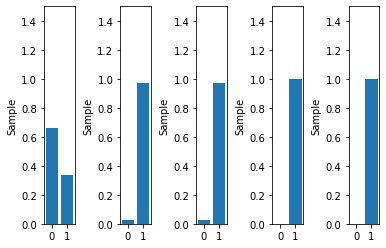

In [35]:
GS_plot = GS_one_plot 


import matplotlib.pyplot as plt
x = range(2)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.5, hspace=None)
plt.subplot(1,5,1)
#This will create the bar graph
pop = plt.bar(x, GS_plot[0,0])
plt.ylabel('Sample')
axes = plt.gca()
axes.set_ylim([0,1.5])
plt.subplot(1,5,2)
#This will create the bar graph
pop = plt.bar(x, GS_plot[1,0])
plt.ylabel('Sample')
axes = plt.gca()
axes.set_ylim([0,1.5])
plt.subplot(1,5,3)
#This will create the bar graph 
pop = plt.bar(x, GS_plot[2,0])
plt.ylabel('Sample')
axes = plt.gca()
axes.set_ylim([0,1.5])
plt.subplot(1,5,4)
#This will create the bar graph 
pop = plt.bar(x, GS_plot[3,0])
plt.ylabel('Sample')
axes = plt.gca()
axes.set_ylim([0,1.5])
plt.subplot(1,5,5)
#This will create the bar graph
pop = plt.bar(x, GS_plot[4,0])
plt.ylabel('Sample')
axes = plt.gca()
axes.set_ylim([0,1.5])

(0.0, 1.5)

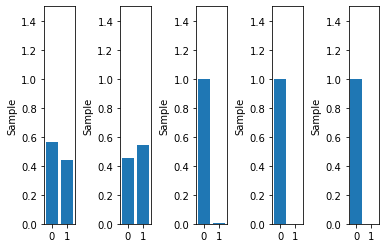

In [36]:
GS_plot = GS_two_plot 

x = range(2)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.5, hspace=None)
plt.subplot(1,5,1)
#This will create the bar graph
pop = plt.bar(x, GS_plot[0,0])
plt.ylabel('Sample')
axes = plt.gca()
axes.set_ylim([0,1.5])
plt.subplot(1,5,2)
#This will create the bar graph
pop = plt.bar(x, GS_plot[1,0])
plt.ylabel('Sample')
axes = plt.gca()
axes.set_ylim([0,1.5])
plt.subplot(1,5,3)
#This will create the bar graph 
pop = plt.bar(x, GS_plot[2,0])
plt.ylabel('Sample')
axes = plt.gca()
axes.set_ylim([0,1.5])
plt.subplot(1,5,4)
#This will create the bar graph 
pop = plt.bar(x, GS_plot[3,0])
plt.ylabel('Sample')
axes = plt.gca()
axes.set_ylim([0,1.5])
plt.subplot(1,5,5)
#This will create the bar graph
pop = plt.bar(x, GS_plot[4,0])
plt.ylabel('Sample')
axes = plt.gca()
axes.set_ylim([0,1.5])

(0.0, 1.5)

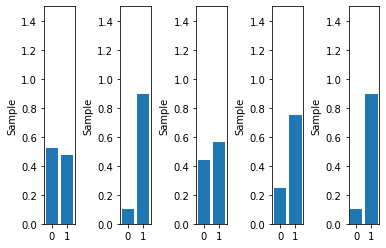

In [37]:
GS_plot = GS_three_plot 

x = range(2)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.5, hspace=None)
plt.subplot(1,5,1)
#This will create the bar graph
pop = plt.bar(x, GS_plot[0,0])
plt.ylabel('Sample')
axes = plt.gca()
axes.set_ylim([0,1.5])
plt.subplot(1,5,2)
#This will create the bar graph
pop = plt.bar(x, GS_plot[1,0])
plt.ylabel('Sample')
axes = plt.gca()
axes.set_ylim([0,1.5])
plt.subplot(1,5,3)
#This will create the bar graph 
pop = plt.bar(x, GS_plot[2,0])
plt.ylabel('Sample')
axes = plt.gca()
axes.set_ylim([0,1.5])
plt.subplot(1,5,4)
#This will create the bar graph 
pop = plt.bar(x, GS_plot[3,0])
plt.ylabel('Sample')
axes = plt.gca()
axes.set_ylim([0,1.5])
plt.subplot(1,5,5)
#This will create the bar graph
pop = plt.bar(x, GS_plot[4,0])
plt.ylabel('Sample')
axes = plt.gca()
axes.set_ylim([0,1.5])

(0.0, 1.5)

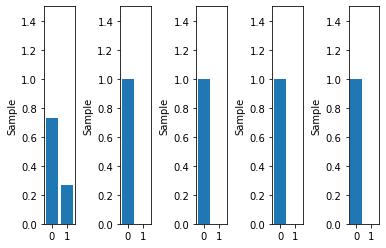

In [38]:
GS_plot = GS_four_plot 

x = range(2)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.5, hspace=None)
plt.subplot(1,5,1)
#This will create the bar graph
pop = plt.bar(x, GS_plot[0,0])
plt.ylabel('Sample')
axes = plt.gca()
axes.set_ylim([0,1.5])
plt.subplot(1,5,2)
#This will create the bar graph
pop = plt.bar(x, GS_plot[1,0])
plt.ylabel('Sample')
axes = plt.gca()
axes.set_ylim([0,1.5])
plt.subplot(1,5,3)
#This will create the bar graph 
pop = plt.bar(x, GS_plot[2,0])
plt.ylabel('Sample')
axes = plt.gca()
axes.set_ylim([0,1.5])
plt.subplot(1,5,4)
#This will create the bar graph 
pop = plt.bar(x, GS_plot[3,0])
plt.ylabel('Sample')
axes = plt.gca()
axes.set_ylim([0,1.5])
plt.subplot(1,5,5)
#This will create the bar graph
pop = plt.bar(x, GS_plot[4,0])
plt.ylabel('Sample')
axes = plt.gca()
axes.set_ylim([0,1.5])

# References

[1] I.Nikoloska, and O. Simeone "Modular Meta-Learning for Power Control via Random Edge Graph Neural Networks", arXiv preprint arXiv:2108.13178, 2020.

[2] C. J. Maddison, A. Mnih, and Y. W. Teh, “The concrete distribution: A continuous relaxation of discrete random variables,”
arXiv preprint arXiv:1611.00712, 2016.

[3] E. Jang, S. Gu, and B. Poole, “Categorical reparameterization with gumbel-softmax,” arXiv preprint arXiv:1611.01144, 2016.